[395.96553958 407.21026056 421.23818801 442.28730914 443.61570429
 450.83479346 451.98521009 452.70951031 453.81737132 476.06844217
 477.01846295 496.02887199 496.40771515 506.42048604 507.45420624
 509.85671608 510.21198555 592.18507887 593.0123241  595.03580435
 672.53503405 712.03232145]
[10775348.45882681 11693970.46962919 10682792.13062436 10766541.71058609
 10734301.59450085 11829906.23330781 11799796.13116673 11780917.36950427
 11752157.74102664 11202870.97587854 11180559.55391086 10752062.2981887
 10743856.65374753 10531432.83175276 10509979.55631098 10460455.19281596
 10453171.39621552 12158361.05450668 12141400.28368755 12100112.20730872
 10705761.98327204 10111900.51786639] 
 [38143.62716118 40186.39406628 35413.37881039 14895.19090142
 33667.89403367 15931.77293146 36273.41334895  7216.55006808
  7145.64687524 13940.43755215 32422.81215526 12569.37893318
 29831.00891922 11916.47863984 28485.04348176 11708.92940483
 28162.54185033 27717.32839916 10362.27758358 10255.20171504

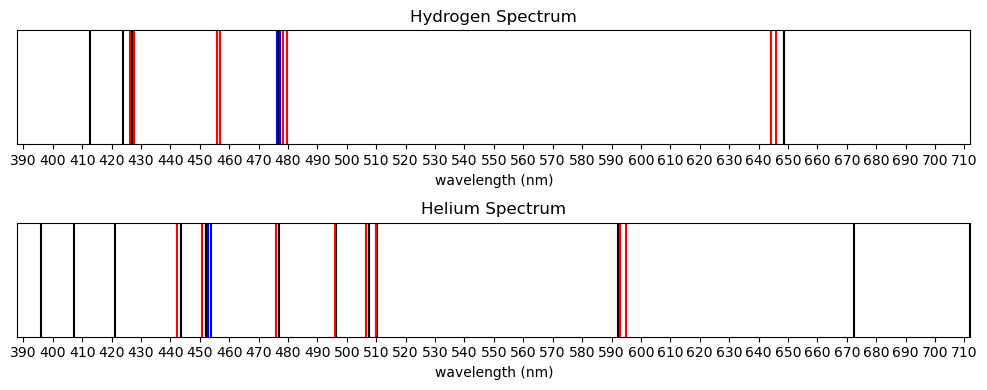

In [33]:
import numpy as np                # imports the numerical library
from matplotlib import pyplot as plt    # imports the plotting library
import math as mth
from os.path import exists

index = []
angle = []
color = []

#experimental parameters
a = 1.66e-3 #in mm. Distance between lines in diffraction grating.
Zp = 55.8 #in degrees. Zero point angle from experimental settup

#Bragg eqn. from lab manuel. Multiply by 10**6 to convert to nanometers.
def bragg(angle, index):
    return a*np.sin(angle)/index*10**6

#Rydberg eqn. Mult by 10**9 to convert to units of m^-1
def ryd(wave, z, nU, nL):
    return 1/wave/z**2*(nU**2)*(nL**2)/(nU**2-nL**2)*10**9

#import data from text files
i = 0
while True: 
    name = "OS Trial "+str(i+1)+".txt"
    if exists(name) == False:
        break
    ind, ang = np.loadtxt(name, skiprows=8, usecols=(0,1), unpack=True)
    index.append(ind)
    angle.append(ang)
    #color.append(c)
    #print("Trial",i+1,"\nIndex:",index[i],"\nAngle",angle[i])
    #print("\nColor:"+color[i]+"\n")
    i+=1

# convert angles to correct values from raw data: Subtract zero point angle from raw angle, Degree to radian conversion
for i, ang in enumerate(angle):
    angle[i] = np.absolute(ang-Zp)*np.pi/180
# print(angle)

#create list of wavelengths for each trial
wavelength = []
waveErr = []
for i, angles in enumerate(angle):
    wavelength.append(bragg(angles, index[i]))
    waveErr.append(bragg(angles+0.05*np.pi/180, index[i])-bragg(angles, index[i]))
#print(waveErr)
#print(wavelength)

#Separate Wavelength Spectrums into one for Hydrogen and one for Helium
HSpect = np.append(wavelength[0],wavelength[1])
HSpectErr = np.append(waveErr[0], waveErr[1])
HIndex = np.append(index[0], index[1])
HeSpect = np.array(wavelength[2])
HeSpectErr = np.array(waveErr[2])
HeIndex = np.array(index[2])
#print(HeSpect, HeIndex)

#plot spectrums
fig = plt.figure(figsize = (10, 4))

ax1 = fig.add_subplot(2, 1, 1) #Hydrogen trials
for i, wave in enumerate(HSpect):
    if HIndex[i] == 1:
        ax1.axvline(x=wave, ymin=0, color='black')
    elif HIndex[i] == 2:
        ax1.axvline(x=wave, color='red')
    else:
        ax1.axvline(x=wave, color='blue')
ax1.set_xticks(ticks = np.arange(390, 720, 10))
ax1.set_xlabel('wavelength (nm)')
ax1.set_title("Hydrogen Spectrum")
ax1.set_xlim(388, 712)
ax1.get_yaxis().set_visible(False)
    
ax2 = fig.add_subplot(2, 1, 2) #Helium trial
for i, wave in enumerate(HeSpect):
    if HeIndex[i] == 1:
        ax2.axvline(x=wave, color='black')
    elif HeIndex[i] == 2:
        ax2.axvline(x=wave, color='red')
    else:
        ax2.axvline(x=wave, color='blue')
ax2.set_xlabel('wavelength (nm)')
ax2.set_xticks(ticks = np.arange(390, 720, 10))
ax2.set_title("Helium Spectrum")
ax2.set_xlim(388, 712)
ax2.get_yaxis().set_visible(False)

fig.tight_layout() #avoids collisions between subplots
#plt.show()

#Put trials in wavelength order
orderH = HSpect.argsort()
HSpect = HSpect[orderH]
HSpectErr = HSpectErr[orderH]
HIndex = HIndex[orderH]
orderHe = HeSpect.argsort()
HeSpect = HeSpect[orderHe]
HeSpectErr = HeSpectErr[orderHe]
HeIndex = HeIndex[orderHe]
#print(HSpect,"\n", HeSpect)
print(HeSpect)

#Calculate Rydberg Constant for Hydrogen trials
#Manually assign upper and lower principle quantum numbers for each wavelength
nU = [5.5, 5, 5, 5, 5, 4.5, 4.5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3]
nL = 2

rydberg = np.empty(len(HSpect))
rydErr = np.empty(len(HSpect))
for i, wave in enumerate(HSpect): 
    rydberg[i] = ryd(wave, 1, nU[i], nL) #Nuclear charge is +1 for Hydrogen
    rydErr[i] = np.absolute(ryd(wave+HSpectErr[i], 1, nU[i], nL) - ryd(wave, 1, nU[i], nL))
# print(rydberg,'\n',rydErr)
# print("Avg Rydberg Const: (",sum(rydberg)/len(rydberg),'+/-',sum(rydErr)/len(rydErr),') m^-1\nActual Value:       ',10973731.568157,'m^-1') #avg

#Calculate Rydberg Constant for Helium trials
#Manually assign upper and lower principle quantum numbers for each wavelength
nU = [8, 5, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3]
nL = 2 #nL for all relevant wavelengths is n=2
lU = [0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]
c = [393.6, 402.6, 414.4, 438.8, 438.8, 447.1, 447.1, 447.1, 447.1, 471.3, 471.3, 492.1, 492.1, 504.8, 504.8, 504.8, 504.8, 
     587.5, 587.5, 587.5, 667.8, 706.5] # corresponding wavelength from database 

# wave_l0 = wave[lU == 0]
# nU_l0 = nU[lU == 0]
# nL_l0 = nL[lU == 0]
# c_l0 = c[lU == 0]

rydberg = np.empty(len(HeSpect))
rydErr = np.empty(len(HeSpect))
for i, wave in enumerate(HeSpect):
    rydberg[i] = ryd(wave, 1, nU[i], nL) #Nuclear charge is +2 for Helium
    rydErr[i] = np.absolute(ryd(wave+HeSpectErr[i], 1, nU[i], nL) - ryd(wave, 1, nU[i], nL))
print(rydberg, '\n', rydErr)
print("Avg Rydberg Const:",sum(rydberg)/len(rydberg),'\nActual Value:     ',10973731.568157,'m^-1') #avg

# print(HeSpect[13], HeSpect[14])
# print(c[13], c[14])
# print(rydberg[13], rydberg[14])
# print(nU[13], nU[14])